In [12]:
using LCIO
using GRUtils
using StatsBase
using JuliaDB
using IterableTables
using DataFrames
using LinearAlgebra

In [13]:
#get strange momenta from higgs decay and higgs momentum itself
momentastrangehiggs = Float64[]
momentahiggs = Float64[]
LCIO.open("E250-TDR_ws.Pe2e2h_ss.Gwhizard-2_82.eR.pL.slcio") do reader
    for event in reader
        for particle in getCollection(event, "MCParticle")
            if getPDG(particle)==25
                x=norm(getMomentum(particle))
                if x>40 && x<80
                    push!(momentahiggs,(norm(getMomentum(particle))))
                end
            end
            parents = [p for p in getParents(particle)[]]
            parentPDG = 0
            if length(parents)>0
                parentPDG = getPDG(parents[1])
            end
            if parentPDG == 25
                push!(momentastrangehiggs, norm(getMomentum(particle)))
            end
        end
    end
end

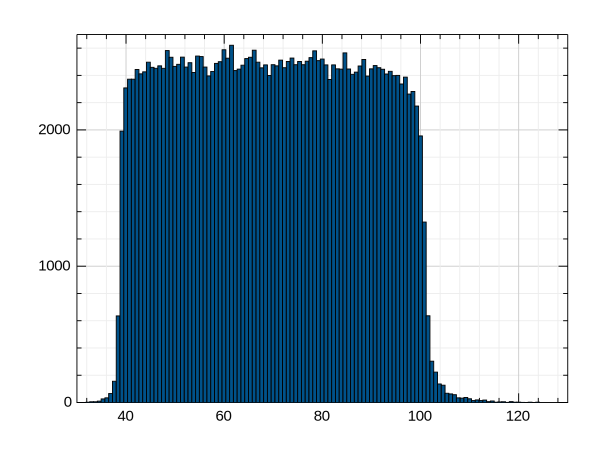

In [14]:
histogram(momentastrangehiggs, nbins = 120)

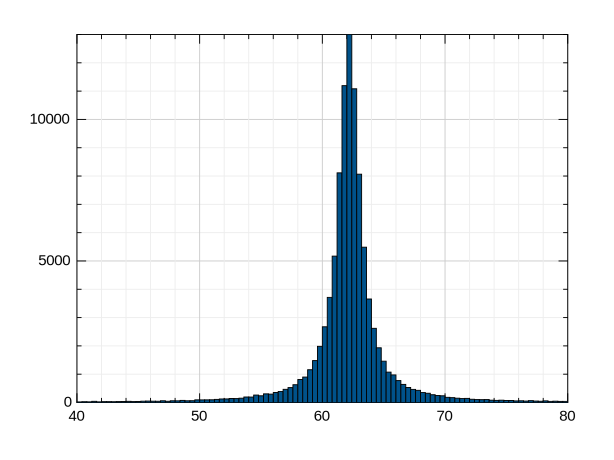

In [15]:
histogram(momentahiggs, nbins=100)

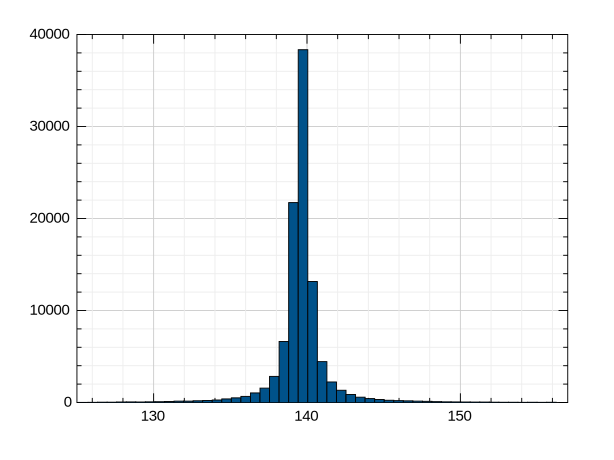

In [16]:
#find what the edges of the distribution are from
LCIO.open("E250-TDR_ws.Pe2e2h_ss.Gwhizard-2_82.eR.pL.slcio") do reader
    energyarray = []
    for event in reader
        for particle in getCollection(event, "MCParticle")
            if getPDG(particle)==25
                daughters = [p for p in getDaughters(particle)[]]
                push!(energyarray,(norm(getMomentum(daughters[1]))+norm(getMomentum(daughters[2]))))
            end
        end
    end
    histogram(energyarray, nbins= 50)
end


In [17]:
#find momenta of final-state strange hadrons originally from higgs - bottom decay
totalMomenta2 = []
function findHadrons2(particle)
    total_list = []
    daughter_list = [p for p in getDaughters(particle)[]]
    if getPDG(particle)>99 || getPDG(particle)<90
        push!(total_list,(getPDG(particle),norm(getMomentum(particle)), getGeneratorStatus(particle)))
    end
    if length(daughter_list)==0
        return total_list
    end
    for x in daughter_list
        if getGeneratorStatus(x)==1 && (getPDG(x)>99 || getPDG(x)<90)
            #println("here")
            push!(total_list,(getPDG(x),norm(getMomentum(x)), getGeneratorStatus(x)))
        else
            return findHadrons2(x)
        end
    end
    return total_list
end

function findstrange(count_dict,len)
    println(len)
    total_strange = 0
    strange_mesons = 0
    strange_baryons = 0
    other_strange = 0
    other = 0
    for (key,value) in count_dict
        key_string = string(abs(key[1]))
        if (key_string[1]=='3' || key_string == "130") && key[2]==1
            total_strange+=value
            if length(key_string)==3
                strange_mesons+=value
            elseif length(key_string)==4
                strange_baryons+=value
            else
                other_strange+=value
            end
        end
    end
    println(other_strange)
    other = len - total_strange
    stringlist = ["strange hadrons","other particles"]
    problist = []
    #push!(problist,(total_strange,sqrt(total_strange)))
    push!(problist,(strange_mesons,sqrt(strange_mesons),strange_mesons/len, sqrt(strange_mesons)/len))
    #push!(problist,(strange_baryons,sqrt(strange_baryons)))
    push!(problist,(other,sqrt(other), other/len, sqrt(other)/len))
    dw = DataFrame(x = stringlist, y = problist)
    table(dw)
end

#reading the file and calling helper functions
LCIO.open("E250-TDR_ws.Pmumuh2bb.Gwhizard-2_11.eL.pR.slcio") do reader
    nEvts = 0
    totalparticlearray = []
    number_events = 0
    for event in reader
        nEvts+=1
        for particle in getCollection(event, "MCParticle")
            pt = getParents(particle)
            parent = [p for p in pt[]]
            parentPDG=0
            if length(parent) > 0
                parentPDG = getPDG(parent[1])
            end
            
            if abs(parentPDG) == 5
                
                parent2 = [q for q in getParents(pt[1])[]]
                parent2PDG=0
                if length(parent2) > 0
                    parent2PDG = getPDG(parent2[1])
                end
                if parent2PDG == 25
                    number_events+=1
                    push!(totalparticlearray,findHadrons2(particle))
                end
                
            end
        end
    end
    println("there are $(nEvts) total events")
    totalparticlearray = collect(Iterators.flatten(totalparticlearray))
    
    totalPDG = [] 
    for x in totalparticlearray
        push!(totalPDG, (x[1],x[3]))
        a = string(abs(x[1]))
        if (a[1] == '3' || a == "130") && x[3]==1
            push!(totalMomenta2, x[2])
        end
    end
    particle_dict = countmap(totalPDG)
    println(particle_dict)
    findstrange(particle_dict,length(totalPDG))
end

there are 100000 total events
Dict{Any,Int64}((11, 1) => 16525,(-321, 1) => 64170,(-16, 1) => 9373,(-14, 1) => 12120,(-511, 2) => 33,(310, 2) => 104202,(2214, 2) => 183,(-431, 2) => 1086,(411, 2) => 5207,(130, 1) => 143083,(-421, 2) => 34447,(22, 1) => 667719,(1114, 2) => 144,(223, 2) => 342,(331, 2) => 360,(313, 2) => 37636,(-311, 2) => 58544,(441, 2) => 50,(20213, 2) => 4,(211, 1) => 220910,(-12, 1) => 11975,(4122, 2) => 946,(16, 1) => 6101,(3122, 2) => 2629,(-5122, 2) => 12,(10221, 2) => 582,(15, 2) => 6101,(221, 2) => 14092,(-4122, 2) => 1605,(511, 2) => 37,(-1114, 2) => 303,(2212, 1) => 4808,(13, 1) => 12387,(-24, 2) => 6,(323, 2) => 48,(-2212, 1) => 7619,(-2224, 2) => 1361,(3112, 2) => 180,(-13, 1) => 10447,(2114, 2) => 175,(-2114, 2) => 246,(5122, 2) => 7,(-313, 2) => 26006,(-3112, 2) => 330,(-2112, 1) => 2520,(-11, 1) => 14447,(333, 2) => 8933,(-3122, 2) => 4247,(421, 2) => 22749,(2112, 1) => 1646,(111, 2) => 321664,(3222, 2) => 376,(20443, 2) => 76,(-411, 2) => 7122,(321, 1) =

Table with 2 rows, 2 columns:
x                  y
────────────────────────────────────────────────────────────
"strange hadrons"  (295661, 543.747, 0.125465, 0.000230741)
"other particles"  (2060868, 1435.57, 0.874535, 0.000609189)

295661


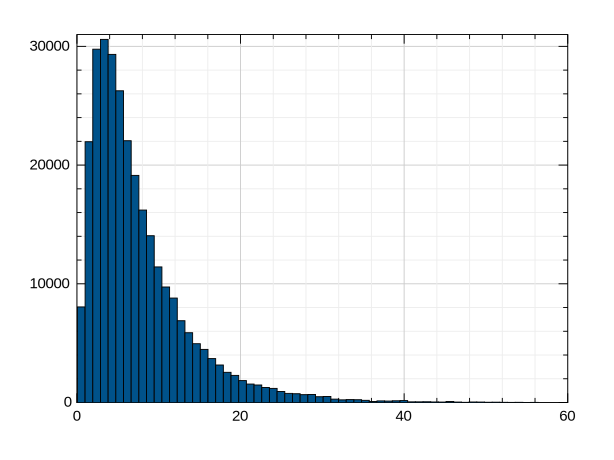

In [18]:
println(length(totalMomenta2))
histogram(totalMomenta2, nbins = 60)

In [19]:
#find momenta of final-state strange hadrons originally from higgs - charm decay
totalMomenta3 = []
function findHadrons2(particle)
    total_list = []
    daughter_list = [p for p in getDaughters(particle)[]]
    if getPDG(particle)>99 || getPDG(particle)<90
        push!(total_list,(getPDG(particle),norm(getMomentum(particle)), getGeneratorStatus(particle)))
    end
    if length(daughter_list)==0
        return total_list
    end
    for x in daughter_list
        if getGeneratorStatus(x)==1 && (getPDG(x)>99 || getPDG(x)<90)
            #println("here")
            push!(total_list,(getPDG(x),norm(getMomentum(x)), getGeneratorStatus(x)))
        else
            return findHadrons2(x)
        end
    end
    return total_list
end

function findstrange(count_dict,len)
    println(len)
    total_strange = 0
    strange_mesons = 0
    strange_baryons = 0
    other_strange = 0
    other = 0
    for (key,value) in count_dict
        key_string = string(abs(key[1]))
        if (key_string[1]=='3' || key_string == "130") && key[2]==1
            total_strange+=value
            if length(key_string)==3
                strange_mesons+=value
            elseif length(key_string)==4
                strange_baryons+=value
            else
                other_strange+=value
            end
        end
    end
    println(other_strange)
    other = len - total_strange
    stringlist = ["strange hadrons","other particles"]
    problist = []
    #push!(problist,(total_strange,sqrt(total_strange)))
    push!(problist,(strange_mesons,sqrt(strange_mesons),strange_mesons/len, sqrt(strange_mesons)/len))
    #push!(problist,(strange_baryons,sqrt(strange_baryons)))
    push!(problist,(other,sqrt(other), other/len, sqrt(other)/len))
    dw = DataFrame(x = stringlist, y = problist)
    table(dw)
end

#reading the file and calling helper functions
LCIO.open("E250-TDR_ws.Pmumuh2cc.Gwhizard-2_11.eL.pR.slcio") do reader
    nEvts = 0
    totalparticlearray = []
    number_events = 0
    for event in reader
        nEvts+=1
        for particle in getCollection(event, "MCParticle")
            pt = getParents(particle)
            parent = [p for p in pt[]]
            parentPDG=0
            if length(parent) > 0
                parentPDG = getPDG(parent[1])
            end
            
            if abs(parentPDG) == 4
                
                parent2 = [q for q in getParents(pt[1])[]]
                parent2PDG=0
                if length(parent2) > 0
                    parent2PDG = getPDG(parent2[1])
                end
                if parent2PDG == 25
                    number_events+=1
                    push!(totalparticlearray,findHadrons2(particle))
                end
                
            end
        end
    end
    println("there are $(nEvts) total events")
    totalparticlearray = collect(Iterators.flatten(totalparticlearray))
    
    totalPDG = [] 
    for x in totalparticlearray
        push!(totalPDG, (x[1],x[3]))
        a = string(abs(x[1]))
        if (a[1] == '3' || a == "130") && x[3]==1
            push!(totalMomenta3, x[2])
        end
    end
    particle_dict = countmap(totalPDG)
    println(particle_dict)
    findstrange(particle_dict,length(totalPDG))
end

there are 100000 total events
Dict{Any,Int64}((11, 1) => 11606,(-321, 1) => 109456,(-16, 1) => 360,(-14, 1) => 7636,(310, 2) => 124351,(2214, 2) => 628,(-431, 2) => 1215,(411, 2) => 8724,(-421, 2) => 27068,(130, 1) => 175142,(22, 1) => 724526,(1114, 2) => 191,(223, 2) => 286,(331, 2) => 468,(313, 2) => 28803,(-311, 2) => 105987,(211, 1) => 278464,(-12, 1) => 7469,(4122, 2) => 2098,(16, 1) => 159,(3122, 2) => 5437,(10221, 2) => 590,(15, 2) => 159,(221, 2) => 15382,(-4122, 2) => 1382,(-1114, 2) => 245,(2212, 1) => 10023,(13, 1) => 7648,(323, 2) => 47,(-2212, 1) => 6499,(3112, 2) => 341,(-2224, 2) => 1123,(-13, 1) => 12588,(2114, 2) => 368,(-2114, 2) => 140,(-313, 2) => 45100,(-3112, 2) => 152,(-2112, 1) => 2584,(-11, 1) => 16186,(333, 2) => 11086,(-3122, 2) => 3711,(421, 2) => 44465,(2112, 1) => 2931,(111, 2) => 346437,(3222, 2) => 979,(-411, 2) => 5861,(321, 1) => 75046,(-3222, 2) => 741,(311, 2) => 69089,(-211, 1) => 250841,(113, 2) => 42464,(-213, 2) => 12,(-2214, 2) => 474,(213, 2) =

Table with 2 rows, 2 columns:
x                  y
───────────────────────────────────────────────────────────
"strange hadrons"  (359644, 599.703, 0.137072, 0.000228567)
"other particles"  (2264108, 1504.7, 0.862928, 0.00057349)

359644


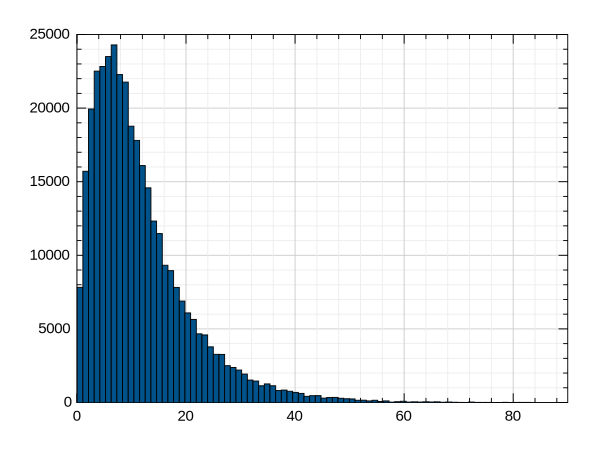

In [20]:
println(length(totalMomenta3))
histogram(totalMomenta3, nbins = 80)

In [21]:
#find momenta of final-state strange hadrons originally from higgs - gluon decay
totalMomenta4 = []
function findHadrons2(particle)
    total_list = []
    daughter_list = [p for p in getDaughters(particle)[]]
    if getPDG(particle)>99 || getPDG(particle)<90
        push!(total_list,(getPDG(particle),norm(getMomentum(particle)), getGeneratorStatus(particle)))
    end
    if length(daughter_list)==0
        return total_list
    end
    for x in daughter_list
        if getGeneratorStatus(x)==1 && (getPDG(x)>99 || getPDG(x)<90)
            #println("here")
            push!(total_list,(getPDG(x),norm(getMomentum(x)), getGeneratorStatus(x)))
        else
            return findHadrons2(x)
        end
    end
    return total_list
end

function findstrange(count_dict,len)
    println(len)
    total_strange = 0
    strange_mesons = 0
    strange_baryons = 0
    other_strange = 0
    other = 0
    for (key,value) in count_dict
        key_string = string(abs(key[1]))
        if (key_string[1]=='3' || key_string == "130") && key[2]==1
            total_strange+=value
            if length(key_string)==3
                strange_mesons+=value
            elseif length(key_string)==4
                strange_baryons+=value
            else
                other_strange+=value
            end
        end
    end
    println(other_strange)
    other = len - total_strange
    stringlist = ["strange hadrons","other particles"]
    problist = []
    #push!(problist,(total_strange,sqrt(total_strange)))
    push!(problist,(strange_mesons,sqrt(strange_mesons),strange_mesons/len, sqrt(strange_mesons)/len))
    #push!(problist,(strange_baryons,sqrt(strange_baryons)))
    push!(problist,(other,sqrt(other), other/len, sqrt(other)/len))
    dw = DataFrame(x = stringlist, y = problist)
    table(dw)
end

#reading the file and calling helper functions
LCIO.open("E250-TDR_ws.Pmumuh2gg.Gwhizard-2_11.eL.pR.slcio") do reader
    nEvts = 0
    totalparticlearray = []
    number_events = 0
    for event in reader
        nEvts+=1
        for particle in getCollection(event, "MCParticle")
            pt = getParents(particle)
            parent = [p for p in pt[]]
            parentPDG=0
            if length(parent) > 0
                parentPDG = getPDG(parent[1])
            end
            
            if abs(parentPDG) == 21
                
                parent2 = [q for q in getParents(pt[1])[]]
                parent2PDG=0
                if length(parent2) > 0
                    parent2PDG = getPDG(parent2[1])
                end
                if parent2PDG == 25
                    number_events+=1
                    push!(totalparticlearray,findHadrons2(particle))
                end
                
            end
        end
    end
    println("there are $(nEvts) total events")
    totalparticlearray = collect(Iterators.flatten(totalparticlearray))
    
    totalPDG = [] 
    for x in totalparticlearray
        push!(totalPDG, (x[1],x[3]))
        a = string(abs(x[1]))
        if (a[1] == '3' || a == "130") && x[3]==1
            if x[2]<41
                push!(totalMomenta4, x[2])
            end
        end
    end
    particle_dict = countmap(totalPDG)
    println(particle_dict)
    findstrange(particle_dict,length(totalPDG))
end

there are 100000 total events
Dict{Any,Int64}((11, 1) => 11196,(-321, 1) => 72363,(-16, 1) => 529,(-14, 1) => 1505,(-511, 2) => 4,(310, 2) => 92438,(2214, 2) => 2977,(-431, 2) => 147,(411, 2) => 1502,(130, 1) => 126765,(-421, 2) => 4980,(22, 1) => 1530435,(1114, 2) => 8499,(223, 2) => 2493,(331, 2) => 658,(313, 2) => 39028,(-311, 2) => 72774,(211, 1) => 338370,(-12, 1) => 1693,(16, 1) => 563,(4122, 2) => 416,(3122, 2) => 15257,(10221, 2) => 50,(15, 2) => 563,(221, 2) => 39733,(-4122, 2) => 184,(-1114, 2) => 6717,(2212, 1) => 27168,(13, 1) => 1549,(323, 2) => 61,(3112, 2) => 3192,(-2224, 2) => 7472,(-2212, 1) => 20249,(-13, 1) => 2752,(2114, 2) => 2879,(-2114, 2) => 1991,(-313, 2) => 50075,(-3112, 2) => 2467,(-2112, 1) => 12494,(-11, 1) => 12161,(333, 2) => 12162,(-3122, 2) => 10533,(421, 2) => 8979,(2112, 1) => 16524,(111, 2) => 731077,(3222, 2) => 1584,(-411, 2) => 1031,(321, 1) => 57493,(-3222, 2) => 1194,(311, 2) => 53991,(113, 2) => 143432,(-211, 1) => 330428,(-213, 2) => 53,(-2214

Table with 2 rows, 2 columns:
x                  y
────────────────────────────────────────────────────────────
"strange hadrons"  (256621, 506.578, 0.0657716, 0.000129835)
"other particles"  (3645078, 1909.21, 0.934228, 0.000489328)

256230


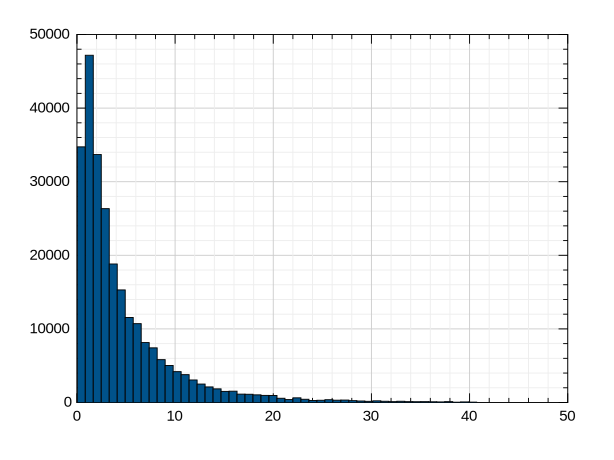

In [22]:
println(length(totalMomenta4))
histogram(totalMomenta4, nbins = 50)